In [2]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from astropy.io import fits
from astropy.table import Table
import optuna
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

c:\Users\victo\anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Cargar los datos a partir de los archivos FITS
# path_datos = "/home/21953404Victor/SDC3/SDC3GIT/data_actualizada/"
# path_repo="/home/21953404Victor/SDC3/SDC3GIT/"
path_datos = "C:/Users/victo/OneDrive/Escritorio/TFG/SDC3/data/"
path_repo="C:/Users/victo/OneDrive/Escritorio/TFG/SDC3/"


path = path_datos + "ZW3.msw_image.fits"
hdul = fits.open(path)

Transformación del catálogo de fuentes completo (almacenado)

In [5]:

# ruta_carpeta_catalogos = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 2/resultados/resultados_detection4"
# ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 2/labels"

ruta_carpeta_catalogos = "C:/Users/victo/OneDrive/Escritorio/TFG/SDC3/catalogos/catalogo completo 3/resultados/resultados_4"
ruta_carpeta_resultados = "C:/Users/victo/OneDrive/Escritorio/TFG/SDC3/catalogos/catalogo completo 3/labels"

archivos = os.listdir(ruta_carpeta_catalogos)

# Función para crear un archivo de anotación para cada catálogo
def crear_anotaciones(path_cat, path_anotacion):
    cat = Table.read(path_cat, format="ascii")
    clase = "fuente"

    with open(path_anotacion, "w") as f:
        for row in cat:
            x = row["X_IMAGE"]
            y = row["Y_IMAGE"]
            f.write(f"{x} {y} {clase}\n")

# Procesar todos los archivos de catálogo en la carpeta
for archivo in archivos:
    # Extraer el número de kHz del nombre del archivo
    num_khz = re.search(r"(\d+)kHz", archivo).group(1)

    # Crear un nombre para el archivo de anotación correspondiente
    anotacion_nombre = f"catalogo_completo_1_{num_khz}kHz.txt"

    # Crear el archivo de anotación para el catálogo actual
    crear_anotaciones(
        os.path.join(ruta_carpeta_catalogos, archivo),
        os.path.join(ruta_carpeta_resultados, anotacion_nombre)
   )


In [4]:
# ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 1/labels"

# archivos = os.listdir(ruta_carpeta_resultados)

# def clamp(value, min_value, max_value):
#     return max(min(value, max_value), min_value)

# def procesar_archivo(path_txt):
#     with open(path_txt, "r") as f:
#         lines = f.readlines()

#     label = np.zeros((2048, 2048), dtype=int)

#     for line in lines:
#         x, y, _ = line.split()
#         x, y = int(float(x)), int(float(y))

#         for i in range(-4, 4):
#             for j in range(-4, 4):
#                 x_coord = clamp(x + i, 0, 2047)
#                 y_coord = clamp(y + j, 0, 2047)
#                 label[y_coord, x_coord] = 1

#     return label

# # Crear una lista para guardar los datos procesados
# target=[]

# # Procesar todos los archivos de texto en la carpeta de resultados
# for archivo in archivos:
#     path_txt = os.path.join(ruta_carpeta_resultados, archivo)
#     label = procesar_archivo(path_txt)
#     target.append(label)


In [5]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
torch.cuda.empty_cache()

## Transformar los datos

In [7]:
probabilidad_imagen=np.mean(fits.open(path_repo+'catalogos/catalogo completo 2/fit/LABEL_COMPLETO_V2.fit')[0].data)
print(probabilidad_imagen)

0.02270133434469242


In [8]:
# Cargar los datos y dividirlos en conjuntos de entrenamiento y validación
data = hdul[0].data

input_data = np.array(data).astype("float32") / 255.0 # Normalizar los datos de entrada (en formato de 8 bits implica que cad píxel tenga un valor de 0 a 255)
input_data = input_data.reshape((data.shape[0], 1, data.shape[1], data.shape[2]))

del hdul
del data

# En lugar de repetir el label ahora se carga la lista de labels. El resto del proceso es igual
output_data = np.array(fits.open(path_repo+'catalogos/catalogo completo 2/fit/LABEL_COMPLETO_V2.fit')[0].data).astype("float32")#[:, np.newaxis, :, :] # Agregar una dimensión para mantener el formato de los datos de entrada de la red neuronal

x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

del input_data
del output_data

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(1)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).unsqueeze(1)

## Arquitectura

In [8]:
def create_decoder(dropout_rate, out_channels1, out_channels2, out_channels3):
    decoder = nn.Sequential(
        nn.ConvTranspose2d(out_channels3, out_channels2, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels2),
        nn.Dropout(dropout_rate),
        nn.ConvTranspose2d(out_channels2, out_channels1, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels1),
        nn.Dropout(dropout_rate),
        nn.ConvTranspose2d(out_channels1, 1, 3, padding=1),
        nn.Sigmoid()
    )
    return decoder.to(device)

def create_encoder(input_channels, num_filters1, num_filters2, dropout_rate, out_channels3):
    encoder = nn.Sequential(
        nn.Conv2d(input_channels, num_filters1, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_filters1),
        nn.MaxPool2d(2, 2),
        nn.Dropout(dropout_rate),
        nn.Conv2d(num_filters1, num_filters2, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_filters2),
        nn.MaxPool2d(2, 2),
        nn.Dropout(dropout_rate),
        nn.Conv2d(num_filters2, out_channels3, 3, padding=1),
        nn.ReLU(),
        nn.Dropout(dropout_rate)
    )
    return encoder.to(device)

### Optimizador de hiperparámetros

In [10]:
def objective(trial):
    # Cargar y dividir los datos en conjuntos de entrenamiento y validación
    global x_train, y_train, x_val, y_val
    
    train_data = TensorDataset(x_train, y_train)
    val_data = TensorDataset(x_val, y_val)

    # Crear DataLoaders para entrenamiento y validación
    batch_size = 1
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Hiperparámetros sugeridos por Optuna
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
    out_channels1 = trial.suggest_int("out_channels1", 16, 64)
    out_channels2 = trial.suggest_int("out_channels2", 16, 64)
    out_channels3 = trial.suggest_int("out_channels3", 16, 64)
    num_filters1 = trial.suggest_int("num_filters1", 16, 64)
    num_filters2 = trial.suggest_int("num_filters2", 16, 64)

    # Imprimir los hiperparámetros utilizados en este trial
    print(f"Hiperparámetros del trial {trial.number}:")
    print(f"lr: {lr}, dropout_rate: {dropout_rate}")
    print(f"out_channels1: {out_channels1}, out_channels2: {out_channels2}, out_channels3: {out_channels3}")
    print(f"num_filters1: {num_filters1}, num_filters2: {num_filters2}")

    # Crear el modelo de 'encoder' y 'decoder' con los hiperparámetros sugeridos
    input_channels = 1
    encoder = create_encoder(input_channels, num_filters1, num_filters2, dropout_rate, out_channels3)
    decoder = create_decoder(dropout_rate, out_channels1, out_channels2, out_channels3)

    # Cuando se define la función de pérdida, se utiliza la estándar para clasificación binaria
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)


    # Crear un directorio para guardar los modelos intermedios, si aún no existe
    os.makedirs("modelos_intermedios", exist_ok=True)
    
    # Entrenamiento y validación del modelo
    num_epochs = 50
    train_losses = []
    val_losses = []

    try:
        for epoch in range(num_epochs):
            encoder.train()
            decoder.train()
            train_loss = 0.0

            #train
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                enc_output = encoder(images)
                dec_output = decoder(enc_output)

                # Convertir las etiquetas a float
                labels_float = labels.float()

                loss = criterion(dec_output, labels_float)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                # Libera memoria en la GPU después de calcular la pérdida
                images = images.cpu()
                labels = labels.cpu()
                torch.cuda.empty_cache()
                
            train_losses.append(train_loss / len(train_loader))
            
            encoder.eval()
            decoder.eval()
            val_loss = 0.0

            #test
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)

                    enc_output = encoder(images)
                    dec_output = decoder(enc_output)
                    dec_output = torch.squeeze(dec_output, dim=1) 

                    # Convertir las etiquetas a float
                    labels_float = labels.float()
                    labels_float = torch.squeeze(labels_float, dim=1)

                    loss = criterion(dec_output, labels_float)

                    val_loss += loss.item()

                    # Libera memoria en la GPU después de calcular la pérdida
                    images = images.cpu()
                    labels = labels.cpu()
                    torch.cuda.empty_cache()
            
            val_losses.append(val_loss / len(val_loader))
            
            print(f"Epoch {epoch+1}/{num_epochs}, Pérdida del train: {train_losses[-1]}, Pérdida del test ultimas 20 épocas: {np.mean(val_losses[-20:])}")

        # Guardar los modelos intermedios
        trial_number = trial.number
        decoder_path = f"modelos_intermedios/decoder_gpu_cat_completo_trial_{trial_number}.pt"
        encoder_path = f"modelos_intermedios/encoder_gpu_cat_completo_trial_{trial_number}.pt"
        
        torch.save(decoder.state_dict(), decoder_path)
        torch.save(encoder.state_dict(), encoder_path)

        # Limpiar la GPU
        del decoder
        del encoder
        torch.cuda.empty_cache()
        
        # Guardar el plot de pérdidas por epoch
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f"modelos_intermedios/loss_plot_trial_{trial_number}.png")
        plt.close()

        return np.mean(val_losses[-20:])  # Devolver la pérdida de validación de los ultimos 20 epochs
    
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(f"[W] El trial {trial.number} falló debido a un error de falta de memoria en la GPU")
            print("Continuando con la optimización de parámetros, ignorando esta última configuración")
            
            # Limpiar la GPU
            del decoder
            del encoder
            torch.cuda.empty_cache()
            
            # Asignar un valor alto para que este trial no sea seleccionado como el mejor
            return float("inf")
        else:
            # Vuelve a generar la excepción si el error no es "CUDA out of memory"
            raise e

    except torch.cuda.OutOfMemoryError:
        print(f"[W] El trial {trial.number} falló debido a un error de falta de memoria en la GPU")
        print("Continuando con la optimización de parámetros, ignorando esta última configuración")
            
        # Limpiar la GPU
        del decoder
        del encoder
        torch.cuda.empty_cache()
            
        # Asignar un valor alto para que este trial no sea seleccionado como el mejor
        return float("inf")


In [1]:
# Crear un estudio de optimización
study = optuna.create_study(direction="minimize")

# Ejecutar el estudio de optimización con la función 'objective' y un número determinado de ensayos
study.optimize(objective, n_trials=15)


NameError: name 'optuna' is not defined

In [ ]:
with open('study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [1]:
from IPython.display import display, Javascript
import nbformat

def save_notebook(file_name):
    display(Javascript('IPython.notebook.save_checkpoint();'))
    with open(file_name, 'r') as f:
        nb = nbformat.read(f, as_version=4)
    nbformat.write(nb, file_name)

# Uso de la función
save_notebook('cnn_gpu_pytorch_completo.ipynb')

<IPython.core.display.Javascript object>

# post entrenamiento

In [9]:
with open('study.pkl', 'rb') as f:
    study = pickle.load(f)

print("Mejor prueba: ")
print(study.best_trial)

print("\nMejores hiperparámetros: ")
print(study.best_trial.params)

Mejor prueba: 
FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.16273348724973793], datetime_start=datetime.datetime(2023, 5, 23, 0, 42, 24, 873186), datetime_complete=datetime.datetime(2023, 5, 23, 1, 50, 31, 341843), params={'lr': 0.00010027415861131253, 'dropout_rate': 0.09585204102585937, 'out_channels1': 44, 'out_channels2': 28, 'out_channels3': 26, 'num_filters1': 61, 'num_filters2': 17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'out_channels1': IntDistribution(high=64, log=False, low=16, step=1), 'out_channels2': IntDistribution(high=64, log=False, low=16, step=1), 'out_channels3': IntDistribution(high=64, log=False, low=16, step=1), 'num_filters1': IntDistribution(high=64, log=False, low=16, step=1), 'num_filters2': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=2, value=None)

Me

In [10]:
# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print("Tasa de aprendizaje:", study.best_params["lr"])
print("Tasa de dropout:", study.best_params["dropout_rate"])
print("Número de filtros en la primera capa convolucional del encoder:", study.best_params["num_filters1"])
print("Número de filtros en la segunda capa convolucional del encoder:", study.best_params["num_filters2"])
print("Número de canales en la primera capa del decoder:", study.best_params["out_channels1"])
print("Número de canales en la segunda capa del decoder:", study.best_params["out_channels2"])
print("Número de canales en la tercera capa del decoder:", study.best_params["out_channels3"])

# Obtener el número del mejor ensayo
best_trial_number = study.best_trial.number

# Crear un nuevo 'decoder' y 'encoder' con los mejores hiperparámetros encontrados
decoder = create_decoder(
    study.best_params["dropout_rate"],
    study.best_params["out_channels1"],
    study.best_params["out_channels2"],
    study.best_params["out_channels3"])

encoder = create_encoder(
    1, # número de canales de entrada
    study.best_params["num_filters1"],
    study.best_params["num_filters2"],
    study.best_params["dropout_rate"],
    study.best_params["out_channels3"]
    )

# Cargar los estados de los mejores modelos
decoder_path = f"modelos_intermedios/decoder_gpu_cat_completo_trial_{best_trial_number}.pt"
encoder_path = f"modelos_intermedios/encoder_gpu_cat_completo_trial_{best_trial_number}.pt"

decoder.load_state_dict(torch.load(decoder_path))
encoder.load_state_dict(torch.load(encoder_path))

Mejores hiperparámetros encontrados:
Tasa de aprendizaje: 0.00010027415861131253
Tasa de dropout: 0.09585204102585937
Número de filtros en la primera capa convolucional del encoder: 61
Número de filtros en la segunda capa convolucional del encoder: 17
Número de canales en la primera capa del decoder: 44
Número de canales en la segunda capa del decoder: 28
Número de canales en la tercera capa del decoder: 26


<All keys matched successfully>

In [47]:
df = pd.DataFrame()
for i, trial in enumerate(study.trials, 1):
    row = trial.params
    row['loss last 20'] = round(trial.value, 4)
    row['rank'] = i
    row['nº ensayo'] = str(trial.number)
    if 'channels' in row:
        row['ch.'] = row.pop('channels')
    if 'filters' in row:
        row['filt.'] = row.pop('filters')
    if 'lr' in row:
        row['learning rate'] = round(row.pop('lr'), 4)
    df = df.append(row, ignore_index=True)

for col in df.columns:
    if df[col].dtype.kind in 'fc':
        df[col] = df[col].round(4)

df = df.sort_values(by='loss last 20')
df['rank'] = range(1, len(df) + 1)
df.set_index('rank', inplace=True)


/tmp/ipykernel_74009/1435658589.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_74009/1435658589.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_74009/1435658589.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_74009/1435658589.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_74009/1435658589.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

In [53]:
# Guarda el DataFrame como un archivo Excel
df.to_excel('ranking_modelos.xlsx', index=False, engine="openpyxl")


## Métricas

In [11]:
with open('study.pkl', 'rb') as f:
    study = pickle.load(f)

# Obtener el número del mejor ensayo
best_trial_number = study.best_trial.number

# Crear un nuevo 'decoder' y 'encoder' con los mejores hiperparámetros encontrados
decoder = create_decoder(
    study.best_params["dropout_rate"],
    study.best_params["out_channels1"],
    study.best_params["out_channels2"],
    study.best_params["out_channels3"])

encoder = create_encoder(
    1, # número de canales de entrada
    study.best_params["num_filters1"],
    study.best_params["num_filters2"],
    study.best_params["dropout_rate"],
    study.best_params["out_channels3"]
    )

# Cargar los estados de los mejores modelos
decoder_path = f"modelos_intermedios/decoder_gpu_cat_completo_trial_{best_trial_number}.pt"
encoder_path = f"modelos_intermedios/encoder_gpu_cat_completo_trial_{best_trial_number}.pt"


In [12]:
data = hdul[0].data

# Normalizar los datos de entrada
input_data = np.array(data).astype("float32") / 255.0
input_data = input_data.reshape((data.shape[0], 1, data.shape[1], data.shape[2]))

# Eliminar variables que ya no se necesitan
del data
del hdul

# Cargar las etiquetas
output_data = np.array(fits.open(path_repo+'catalogos/catalogo completo 2/fit/LABEL_COMPLETO_V2.fit')[0].data).astype("float32")

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

# Eliminar variables que ya no se necesitan
del input_data
del output_data

# Convertir los datos a tensores de PyTorch
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(1)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).unsqueeze(1)


In [13]:
torch.cuda.empty_cache()

In [14]:
# Definir los umbrales
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

# Crear un DataLoader con lotes de 20 imágenes
batch_size = 5
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Almacenar las métricas para cada umbral
metrics = {threshold: {"precision": [], "recall": [], "f1": [], "specificity": []} for threshold in thresholds}

# Establecer el modelo en modo de evaluación
encoder.eval()
decoder.eval()


Sequential(
  (0): ConvTranspose2d(26, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.09585204102585937, inplace=False)
  (4): ConvTranspose2d(28, 44, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.09585204102585937, inplace=False)
  (8): ConvTranspose2d(44, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Sigmoid()
)

In [15]:
# Iterar sobre los lotes de datos
for i, (x_batch, y_batch) in enumerate(val_loader):
    with torch.no_grad():
        x_batch = x_batch.to(device)
        enc_output = encoder(x_batch)
        y_pred = decoder(enc_output).cpu()

        # Iterar sobre los umbrales
        for threshold in thresholds:
            y_pred_bin = (y_pred > threshold).numpy()

            # Calcular la matriz de confusión
            cm = confusion_matrix(y_batch.numpy().flatten(), y_pred_bin.flatten())

            # Calcular las métricas de interés
            precision = precision_score(y_batch.numpy().flatten(), y_pred_bin.flatten(), zero_division=1)

            recall = recall_score(y_batch.numpy().flatten(), y_pred_bin.flatten())
            f1 = f1_score(y_batch.numpy().flatten(), y_pred_bin.flatten())

            # Especificidad: (Verdaderos negativos) / (Verdaderos negativos + Falsos positivos)
            specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

            # Almacenar las métricas
            metrics[threshold]["precision"].append(precision)
            metrics[threshold]["recall"].append(recall)
            metrics[threshold]["f1"].append(f1)
            metrics[threshold]["specificity"].append(specificity)

    # Liberar la memoria ocupada por las variables que ya no se utilizan
    del x_batch
    del y_batch
    del y_pred
    del y_pred_bin
    del enc_output
    torch.cuda.empty_cache()

    # Imprimir el progreso
    if i % 10 == 0:  # Cambia este número si deseas ver las actualizaciones más o menos frecuentemente
        print(f"Procesado lote {i} de {len(val_loader)}")

print("Finalizado.")


Procesado lote 0 de 37
Procesado lote 10 de 37
Procesado lote 20 de 37
Procesado lote 30 de 37
Finalizado.



Umbral: 0.5
Precision: 0.0226917653470426
Recall: 1.0
F1: 0.044375456587806936
Specificity: 0.0

Umbral: 0.6
Precision: 0.022711796783820213
Recall: 0.12498775109774823
F1: 0.03843314281623698
Specificity: 0.8751251067401643

Umbral: 0.7
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.8
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.9
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0


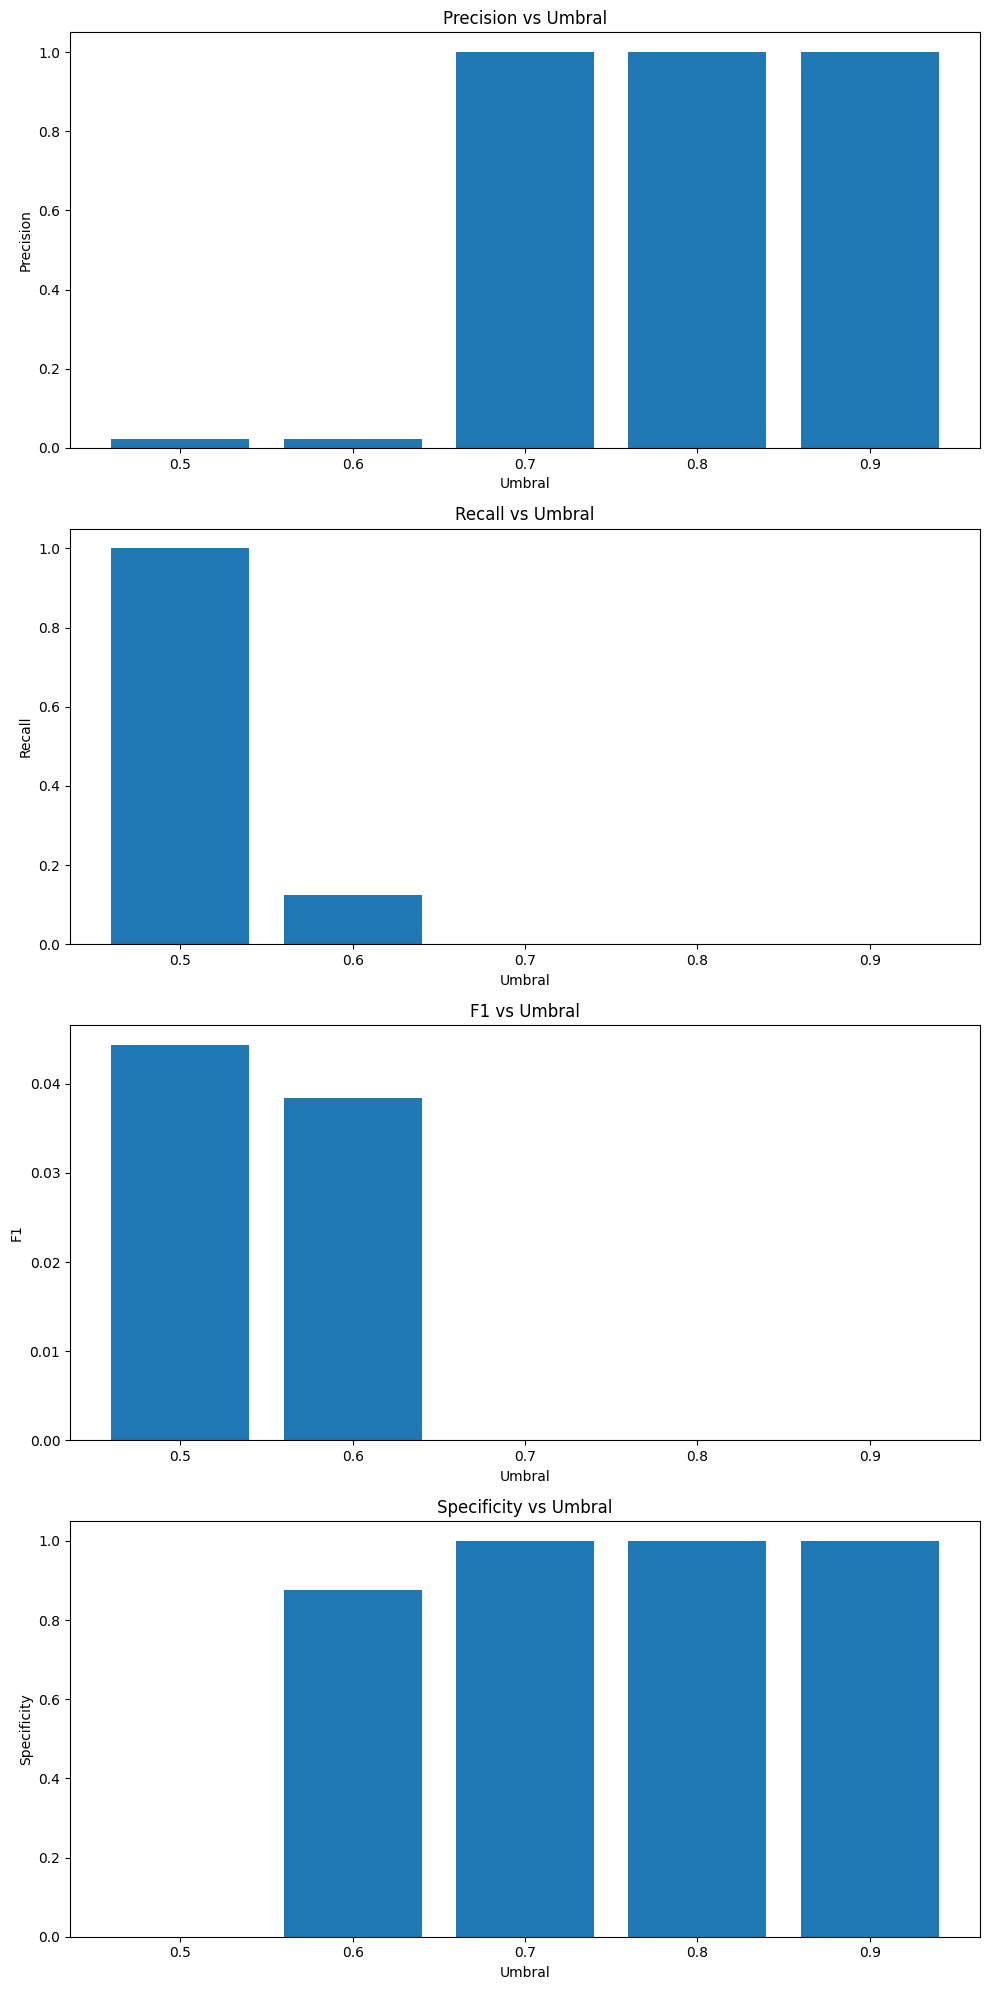

In [17]:
# Calcular la media de las métricas para cada umbral
results = {}  # Diccionario para almacenar resultados
for threshold in thresholds:
    print(f"\nUmbral: {threshold}")
    results[threshold] = {}  # Diccionario para almacenar resultados de un umbral
    for metric, values in metrics[threshold].items():
        mean_value = np.mean(values)
        print(f"{metric.capitalize()}: {mean_value}")
        results[threshold][metric] = mean_value  # Almacenar resultado

# Crear DataFrame con resultados
df_results = pd.DataFrame(results)

# Dibujar las gráficas de barras
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
for i, metric in enumerate(["precision", "recall", "f1", "specificity"]):
    mean_values = [np.mean(metrics[threshold][metric]) for threshold in thresholds]
    ax[i].bar([str(threshold) for threshold in thresholds], mean_values)
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_xlabel("Umbral")
    ax[i].set_title(f"{metric.capitalize()} vs Umbral")

plt.tight_layout()
plt.show()


In [19]:
df_results.to_csv("Metricas.csv")

In [2]:
import pandas as pd
df_results=pd.read_csv("Metricas.csv")
df_results.head()

,Unnamed: 0,0.5,0.6,0.7,0.8,0.9
0,precision,0.022692,0.022712,1.0,1.0,1.0
1,recall,1.000000,0.124988,0.0,0.0,0.0
2,f1,0.044375,0.038433,0.0,0.0,0.0
3,specificity,0.000000,0.875125,1.0,1.0,1.0


In [2]:
from IPython.display import display, Javascript
import nbformat

def save_notebook(file_name):
    display(Javascript('IPython.notebook.save_checkpoint();'))
    with open(file_name, 'r') as f:
        nb = nbformat.read(f, as_version=4)
    nbformat.write(nb, file_name)

# Uso de la función
save_notebook('cnn_gpu_pytorch_completo.ipynb')

<IPython.core.display.Javascript object>

## Métricas 2

In [9]:
with open('study.pkl', 'rb') as f:
    study = pickle.load(f)

# Obtener el número del mejor ensayo
best_trial_number = study.best_trial.number

# Crear un nuevo 'decoder' y 'encoder' con los mejores hiperparámetros encontrados
decoder = create_decoder(
    study.best_params["dropout_rate"],
    study.best_params["out_channels1"],
    study.best_params["out_channels2"],
    study.best_params["out_channels3"])

encoder = create_encoder(
    1, # número de canales de entrada
    study.best_params["num_filters1"],
    study.best_params["num_filters2"],
    study.best_params["dropout_rate"],
    study.best_params["out_channels3"]
    )

# Cargar los estados de los mejores modelos
decoder_path = f"modelos_intermedios/decoder_gpu_cat_completo_trial_{best_trial_number}.pt"
encoder_path = f"modelos_intermedios/encoder_gpu_cat_completo_trial_{best_trial_number}.pt"

In [10]:
data = hdul[0].data

# Normalizar los datos de entrada
input_data = np.array(data).astype("float32") / 255.0
input_data = input_data.reshape((data.shape[0], 1, data.shape[1], data.shape[2]))

# Eliminar variables que ya no se necesitan
del data
del hdul

# Cargar las etiquetas
output_data = np.array(fits.open(path_repo+'catalogos/catalogo completo 2/fit/LABEL_COMPLETO_V2.fit')[0].data).astype("float32")

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

# Eliminar variables que ya no se necesitan
del input_data
del output_data

# Convertir los datos a tensores de PyTorch
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(1)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).unsqueeze(1)

In [11]:
print(np.shape(x_train))
print(np.shape(y_train))

torch.Size([720, 1, 2048, 2048])
torch.Size([720, 1, 2048, 2048])


In [12]:
# Definir los umbrales
thresholds = [0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.565, 0.57, 0.575, 0.58, 0.585, 0.59, 0.595]

# Crear un DataLoader con lotes de 20 imágenes
batch_size = 5
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Almacenar las métricas para cada umbral
metrics = {threshold: {"precision": [], "recall": [], "f1": [], "specificity": []} for threshold in thresholds}

# Establecer el modelo en modo de evaluación
encoder.eval()
decoder.eval()

Sequential(
  (0): ConvTranspose2d(26, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.09585204102585937, inplace=False)
  (4): ConvTranspose2d(28, 44, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.09585204102585937, inplace=False)
  (8): ConvTranspose2d(44, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Sigmoid()
)

In [13]:
# Iterar sobre los lotes de datos
for i, (x_batch, y_batch) in enumerate(val_loader):
    with torch.no_grad():
        x_batch = x_batch.to(device)
        enc_output = encoder(x_batch)
        y_pred = decoder(enc_output).cpu()

        # Iterar sobre los umbrales
        for threshold in thresholds:
            y_pred_bin = (y_pred > threshold).numpy()

            # Calcular la matriz de confusión
            cm = confusion_matrix(y_batch.numpy().flatten(), y_pred_bin.flatten())

            # Calcular las métricas de interés
            precision = precision_score(y_batch.numpy().flatten(), y_pred_bin.flatten(), zero_division=1)

            recall = recall_score(y_batch.numpy().flatten(), y_pred_bin.flatten())
            f1 = f1_score(y_batch.numpy().flatten(), y_pred_bin.flatten())

            # Especificidad: (Verdaderos negativos) / (Verdaderos negativos + Falsos positivos)
            specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

            # Almacenar las métricas
            metrics[threshold]["precision"].append(precision)
            metrics[threshold]["recall"].append(recall)
            metrics[threshold]["f1"].append(f1)
            metrics[threshold]["specificity"].append(specificity)

    # Liberar la memoria ocupada por las variables que ya no se utilizan
    del x_batch
    del y_batch
    del y_pred
    del y_pred_bin
    del enc_output
    torch.cuda.empty_cache()

    # Imprimir el progreso
    if i % 10 == 0: 
        print(f"Procesado lote {i} de {len(val_loader)}")

print("Finalizado.")

Procesado lote 0 de 37
Procesado lote 10 de 37
Procesado lote 20 de 37
Procesado lote 30 de 37
Finalizado.



Umbral: 0.5
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.505
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.51
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.515
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.52
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.525
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.53
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.535
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.54
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.545
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.55
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.555
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.56
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.565
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umbral: 0.57
Precision: 1.0
Recall: 0.0
F1: 0.0
Specificity: 1.0

Umb

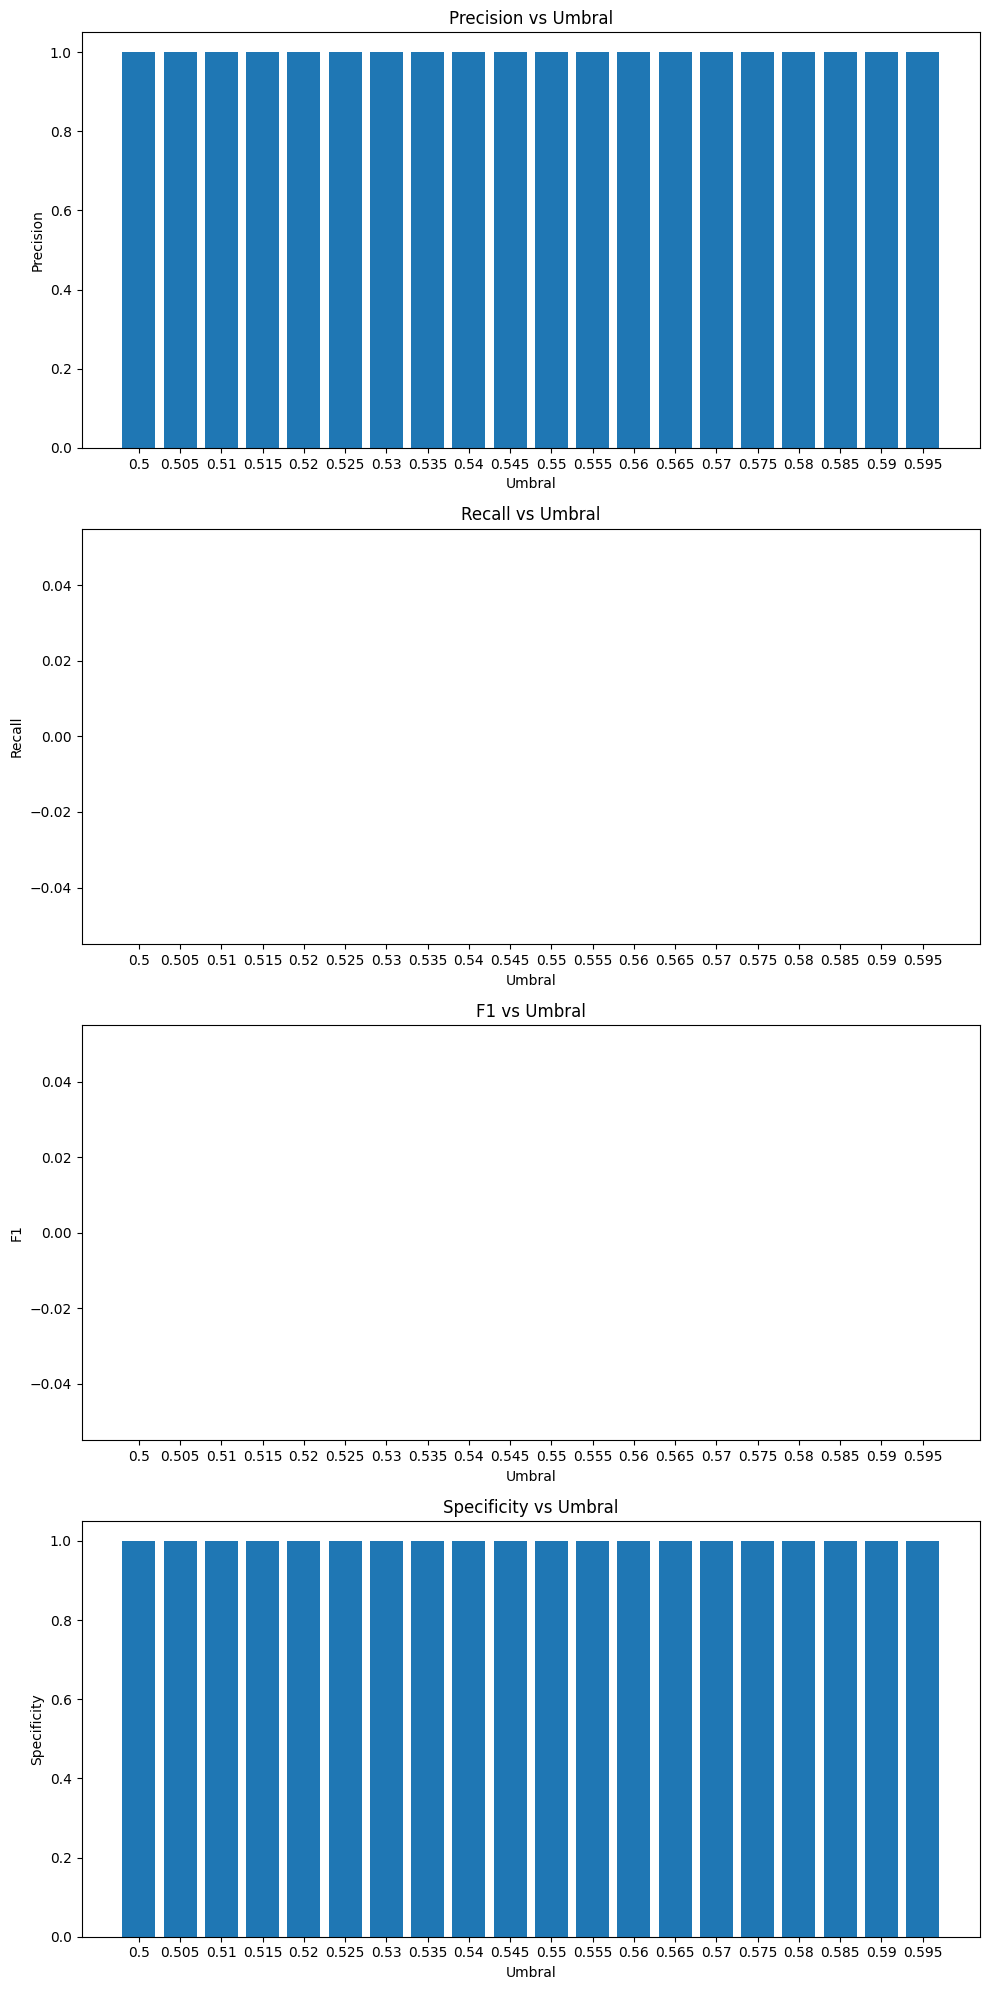

In [14]:
# Calcular la media de las métricas para cada umbral
results = {}  # Diccionario para almacenar resultados
for threshold in thresholds:
    print(f"\nUmbral: {threshold}")
    results[threshold] = {}  # Diccionario para almacenar resultados de un umbral
    for metric, values in metrics[threshold].items():
        mean_value = np.mean(values)
        print(f"{metric.capitalize()}: {mean_value}")
        results[threshold][metric] = mean_value  # Almacenar resultado

# Crear DataFrame con resultados
df_results = pd.DataFrame(results)

# Dibujar las gráficas de barras
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
for i, metric in enumerate(["precision", "recall", "f1", "specificity"]):
    mean_values = [np.mean(metrics[threshold][metric]) for threshold in thresholds]
    ax[i].bar([str(threshold) for threshold in thresholds], mean_values)
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_xlabel("Umbral")
    ax[i].set_title(f"{metric.capitalize()} vs Umbral")

plt.tight_layout()
plt.show()

In [15]:
df_results.to_csv("Metricas2.csv")

In [1]:
import pandas as pd
df_results=pd.read_csv("Metricas2.csv")
df_results.head()

,Unnamed: 0,0.5,0.505,0.51,0.515,0.52,0.525,0.53,0.535,0.54,...,0.55,0.555,0.56,0.565,0.57,0.575,0.58,0.585,0.59,0.595
0,precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,specificity,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
from IPython.display import display, Javascript
import nbformat

def save_notebook(file_name):
    display(Javascript('IPython.notebook.save_checkpoint();'))
    with open(file_name, 'r') as f:
        nb = nbformat.read(f, as_version=4)
    nbformat.write(nb, file_name)

# Uso de la función
save_notebook('cnn_gpu_pytorch_completo.ipynb')

<IPython.core.display.Javascript object>